In [1]:
import stlearn as st
st.settings.set_figure_params(dpi=300)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import sys; import scanpy as sc
from pathlib import Path
from typing import Optional, Union
from anndata import AnnData
import pandas as pd
import stlearn
from typing import Optional, Union
from anndata import AnnData
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import seaborn as sns
import numpy as np
import os
from sklearn.multioutput import MultiOutputClassifier
import pandas as pd
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer
import os
from keras.applications.imagenet_utils import decode_predictions
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score
from skimage.color import rgb2hed
%matplotlib inline
import pandas as pd
from keras.utils import to_categorical
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sys
from numpy import load
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from keras.optimizers import SGD, Adam
from keras.models import Model
from tensorflow.keras import regularizers
from keras.applications.resnet50 import ResNet50, preprocess_input
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import lime
from sklearn.preprocessing import MinMaxScaler
from lime import lime_image
from skimage.segmentation import mark_boundaries
from skimage.segmentation import watershed
import glob
import os
from tensorflow.keras.preprocessing import image as image_fun
from sklearn.preprocessing import OneHotEncoder
import skimage
from skimage.color import rgb2hed
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label
import scipy as sp
from scipy import ndimage as ndi
from skimage.morphology import area_opening
import math; import copy
from sklearn.model_selection import StratifiedKFold


def tiling(
        adata: AnnData,
        out_path: Union[Path, str] = "./tiling",
        library_id: str = None,
        crop_size: int = 40,
        target_size: int = 299,
        verbose: bool = False,
        copy: bool = False,
) -> Optional[AnnData]:
    

    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    # Check the exist of out_path
    if not os.path.isdir(out_path):
        os.mkdir(out_path)

    image = adata.uns["spatial"][library_id]["images"][adata.uns["spatial"]["use_quality"]]
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)
    img_pillow = Image.fromarray(image)
    tile_names = []

    with tqdm(
            total=len(adata),
            desc="Tiling image",
            bar_format="{l_bar}{bar} [ time left: {remaining} ]",
    ) as pbar:
        for imagerow, imagecol in zip(adata.obs["imagerow"], adata.obs["imagecol"]):
            imagerow_down = imagerow - crop_size / 2
            imagerow_up = imagerow + crop_size / 2
            imagecol_left = imagecol - crop_size / 2
            imagecol_right = imagecol + crop_size / 2
            tile = img_pillow.crop(
                (imagecol_left, imagerow_down, imagecol_right, imagerow_up)
            )
            # tile.thumbnail((target_size, target_size), Image.ANTIALIAS)
            tile = tile.resize((target_size, target_size))
            tile_name = library_id + "-" + str(imagecol) + "-" + str(imagerow) + "-" + str(crop_size)#np.arange(len(pd.Series(adata))+1).astype(str).str.zfill(4)+1 + "-" +
            out_tile = Path(out_path) / (tile_name + ".jpeg")
            tile_names.append(str(out_tile))
            if verbose:
                print(
                    "generate tile at location ({}, {})".format(
                        str(imagecol), str(imagerow)
                    )
                )
            tile.save(out_tile, "JPEG")

            pbar.update(1)

    adata.obs["tile_path"] = tile_names
    return adata if copy else None

# 10X

In [2]:
BASE_PATH = Path("D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files")
TILE_PATH = BASE_PATH / "big_tiles"
TILE_PATH.mkdir(parents=True, exist_ok=True)


SAMPLE = "block1"
Sample1 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="V1_Breast_Cancer_Block_A_Section_1_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
img = plt.imread(BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif", 0)
Sample1.uns["spatial"][SAMPLE]['images']["fulres"] = img


SAMPLE = "block2"
Sample2 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="V1_Breast_Cancer_Block_A_Section_2_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
                  #source_image_path=BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_1_image.tif")
img = plt.imread(BASE_PATH / SAMPLE /"V1_Breast_Cancer_Block_A_Section_2_image.tif", 0)
Sample2.uns["spatial"][SAMPLE]['images']["fulres"] = img

Sample1_un_norm, Sample2_un_norm = copy.copy(Sample1), copy.copy(Sample2)

for adata in [Sample1,Sample2,]:
    #Preprocessing
    st.pp.filter_genes(adata,min_cells=3)
    st.pp.log1p(adata)
    sc.pp.filter_cells(adata,min_counts=100)
    
    TILE_PATH_ = TILE_PATH / list(adata.uns["spatial"].keys())[0]
    TILE_PATH_.mkdir(parents=True, exist_ok=True)
    #tiling(adata, TILE_PATH_, crop_size=1950)
    #st.pp.extract_feature(adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Log transformation step is finished in adata.X
Log transformation step is finished in adata.X


# FFPE

In [3]:
BASE_PATH = Path("D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files")
TILE_PATH = BASE_PATH / "big_tiles"
TILE_PATH.mkdir(parents=True, exist_ok=True)


SAMPLE = "FFPE_Breast_Cancer"
Sample3 = st.Read10X(BASE_PATH / SAMPLE, 
                  library_id=SAMPLE, 
                  count_file="Visium_FFPE_Human_Breast_Cancer_filtered_feature_bc_matrix.h5",
                  quality="fulres",)
img = plt.imread(BASE_PATH / SAMPLE /"Visium_FFPE_Human_Breast_Cancer_image.tif", 0)
Sample3.uns["spatial"][SAMPLE]['images']["fulres"] = img


Sample3_un_norm = copy.copy(Sample3)
for adata in [Sample3,]:
     
    st.pp.filter_genes(adata,min_cells=3)
    sc.pp.filter_cells(adata,min_counts=100)
    st.pp.log1p(adata)
    
    TILE_PATH_ = TILE_PATH / list(adata.uns["spatial"].keys())[0]
    TILE_PATH_.mkdir(parents=True, exist_ok=True)
    #tiling(adata, TILE_PATH_, crop_size=1650)
    #st.pp.extract_feature(adata)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


Log transformation step is finished in adata.X


In [86]:
"""wd = 'D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/'
pd.DataFrame(Sample3.obsm['X_tile_feature']).to_csv(wd+'FFPE_big.csv')"""

# 10X

# FFPE

In [4]:
wd = 'D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/'
Sample1_resnet = pd.read_csv(wd+'Sample1A.csv').iloc[:,1:] #Renset Features of Small 299 size tiles adata.obsm[X_tile_feature] --> saved as dataframe
Sample1_big_resnet = pd.read_csv(wd+'Sample1_big.csv').iloc[:,1:] # Renset Features of Small 1950 size tiles adata.obsm[X_tile_feature] --> saved as dataframe
X_train = pd.concat([Sample1_resnet, Sample1_big_resnet],axis=1)
X_train.columns = np.arange(len(X_train.columns))

Sample2_resnet = pd.read_csv(wd+'Sample2A.csv').iloc[:,1:] #Renset Features of Small 299 size tiles adata.obsm[X_tile_feature] --> saved as dataframe
Sample2_big_resnet = pd.read_csv(wd+'Sample2_big.csv').iloc[:,1:]
X_test = pd.concat([Sample2_resnet, Sample2_big_resnet],axis=1)
X_test.columns = np.arange(len(X_test.columns))

Sample2_resnet_ffpe = pd.read_csv(wd+'FFPE.csv').iloc[:,1:] #Renset Features of Small 299 size tiles adata.obsm[X_tile_feature] --> saved as dataframe
Sample2_big_resnet_ffpe = pd.read_csv(wd+'FFPE_big.csv').iloc[:,1:]
X_test_ffpe = pd.concat([Sample2_resnet_ffpe, Sample2_big_resnet_ffpe],axis=1)
X_test_ffpe.columns = np.arange(len(X_test_ffpe.columns))

print(X_train.shape, X_test.shape, X_test_ffpe.shape)

(3798, 4096) (3986, 4096) (2518, 4096)


## Train

In [16]:
from sklearn.multioutput import MultiOutputClassifier; import lightgbm as lgb
import pandas as pd; import shap; import numpy as np; import joblib
from sklearn import preprocessing; from sklearn.preprocessing import LabelEncoder;
from sklearn import preprocessing; from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import roc_auc_score; from sklearn.model_selection import train_test_split; from sklearn.neural_network import MLPClassifier; from sklearn.neural_network import MLPRegressor

biomarker_list_1 = ['COX6C']#,'TTLL12','PGM5','KRT5','SLITRK6', 'CPB1', "PABPC1", "GNAS", "HSP90AB1", "TFF3", "ATP1A1", "B2M", "FASN"]
#["COX6C", "FASN", "ACTG1", "HLA-B",'MALAT1','TTLL12','PGM5','KRT5','LINC00645','SLITRK6', 'CPB1', "HSP90AB1", "TFF3", "ATP1A1"]#"PABPC1", "GNAS"

model_c = MLPClassifier(max_iter=10000)#lgb.LGBMClassifier()#
model_r = MLPRegressor(max_iter=10000)#lgb.LGBMRegressor()
    
MinMax_scaler_y_1 = preprocessing.MinMaxScaler(feature_range =(0, 1))
MinMax_scaler_y_2 = preprocessing.MinMaxScaler(feature_range =(0, 1))

Y_1 = Sample1.to_df()[biomarker_list_1]
Y_1 = MinMax_scaler_y_1.fit_transform(Y_1) 
Y_1 = pd.DataFrame(data=Y_1)
Y_1 = Y_1.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1.01], labels = [0, 1]))
#Y_1 = Y_1.apply(lambda x: pd.qcut(x, 2,duplicates='drop',labels=False))"""

test_Y_1 = Sample2.to_df()[biomarker_list_1]
test_Y_1 = MinMax_scaler_y_2.fit_transform(test_Y_1)
test_Y_1 = pd.DataFrame(data=test_Y_1)
test_Y_1 = test_Y_1.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1.01], labels = [0, 1]))
#test_Y_1 = test_Y_1.apply(lambda x: pd.qcut(x, 2,duplicates='drop',labels=False))
test_Y_1 = test_Y_1.fillna(0)

Y_1 = Y_1.astype('int64')
test_Y_1 = test_Y_1.astype('int64')

In [18]:
kf = StratifiedKFold(n_splits = 5)

scores = []; best_index = []
for i, j in kf.split(X_train, Y_1):
    x_train = X_train.iloc[i]
    y_train = Y_1.iloc[i]
    model = model_c.fit(x_train,y_train)
    predictions = model.predict(X_test)
    best_index.append(i)
    scores.append(roc_auc_score(predictions, test_Y_1))
    
print('Scores from each Iteration: ', scores)
print('Average K-Fold Score :' , np.mean(scores))

clf = model_c.fit(X_train.iloc[best_index[argmax(scores)]], Y_1.iloc[best_index[argmax(scores)]])#model_c.fit(X_train, Y_1)#
pred = clf.predict(X_test)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Scores from each Iteration:  [0.6185373212718674, 0.6181952214362405, 0.6193674594557468, 0.6229952858970398, 0.6255550935822474]
Average K-Fold Score : 0.6209300763286283


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


# Regression

In [16]:
X_test_ffpe["pred"] = pred
X_train["true"] = Y_1

In [21]:
reg = model_r.fit(X_train, Sample1.to_df()["PABPC1"].values)
pred2 = reg.predict(X_test_ffpe)

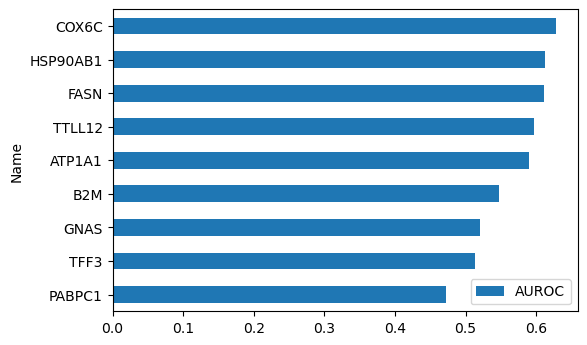

In [99]:
auroc = pd.DataFrame({'Name':['COX6C','TTLL12', "PABPC1", "GNAS", "HSP90AB1", "TFF3", "ATP1A1", "B2M", "FASN"],
        'AUROC':[0.6275, 0.597, 0.473, 0.521, 0.613, 0.513, 0.590, 0.548, 0.611]})
auroc = auroc.set_index('Name')
ax = auroc.sort_values("AUROC").plot.barh()
fig = ax.get_figure()
fig.savefig(wd+'AUROC_FFPE.jpeg')

In [ ]:
roc = pd.DataFrame(index = biomarker_list_1)

AUROC = []
for i in range(len(pred[0])):
    score = roc_auc_score(pred[:,i], test_Y_1.iloc[:,i])
    AUROC.append(score)
roc["AUROC"] = AUROC

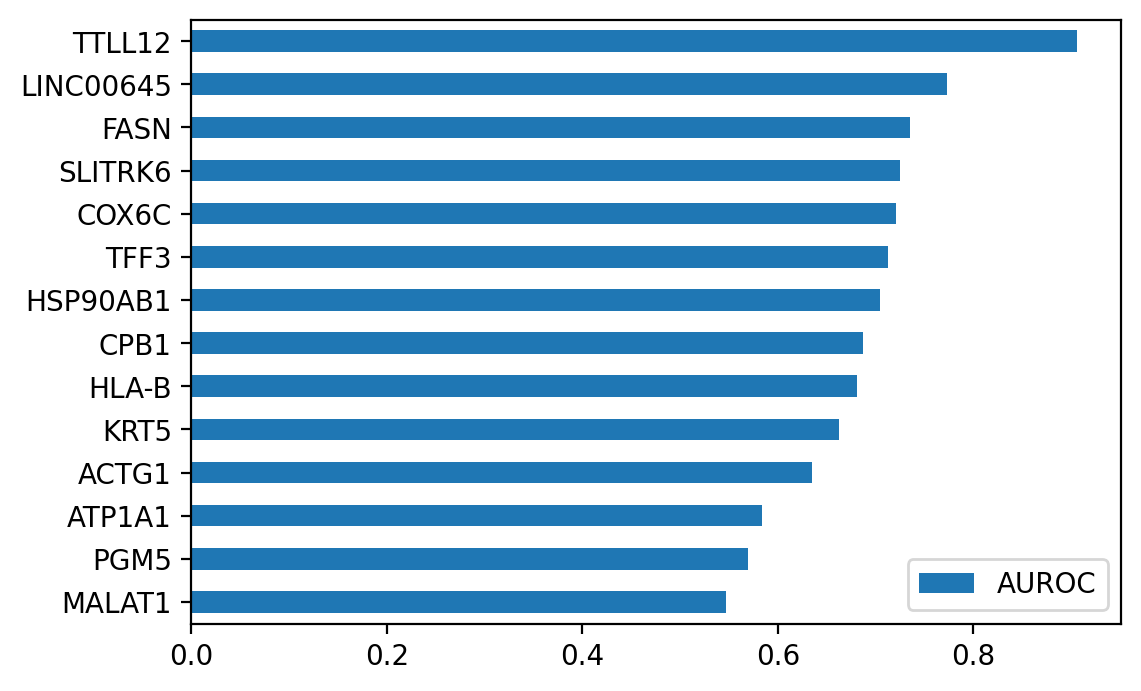

In [113]:
ax = roc.sort_values("AUROC").plot.barh()
fig = ax.get_figure()
fig.savefig(wd+'AUROC_FFPE.jpeg')

# Visualisation GE

# FASN -- FFPE

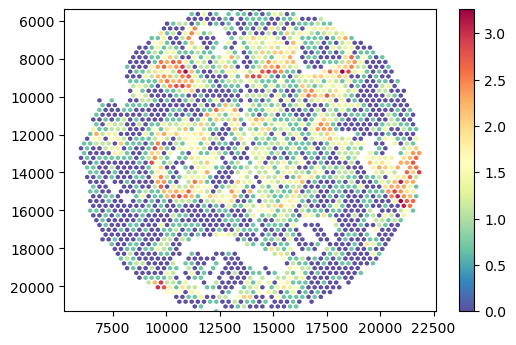

In [9]:
from matplotlib import cm as cm
import numpy as np
from matplotlib import pyplot as plt

x = Sample3.obs["imagerow"] 
y = Sample3.obs["imagecol"] 

c = Sample3.to_df()["FASN"]#test_Y_1#

fig1 = plt.gcf()
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 400
plt.hexbin(y,x, C=c, cmap=cm.Spectral_r, gridsize=110)
plt.ylim(max(x), min(x)) 
plt.colorbar()
plt.show() 
#plt.draw()
#fig1.savefig(wd+'PABPC1_true-FFPE.jpeg')

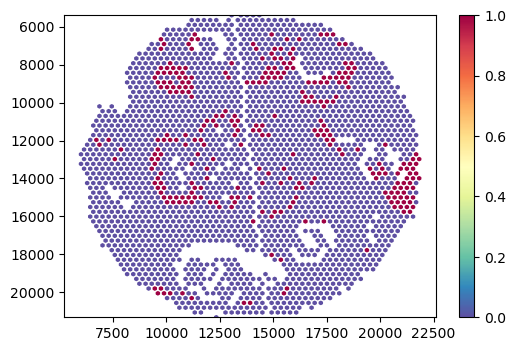

In [11]:
from matplotlib import cm as cm
import numpy as np
from matplotlib import pyplot as plt

x = Sample3.obs["imagerow"] 
y = Sample3.obs["imagecol"] 

c = test_Y_1

fig1 = plt.gcf()
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 400
plt.hexbin(y,x, C=c, cmap=cm.Spectral_r, gridsize=110)
plt.ylim(max(x), min(x)) 
plt.colorbar()
plt.show() 
#plt.draw()
#fig1.savefig(wd+'PABPC1_true_class-FFPE.jpeg')

### Predicted

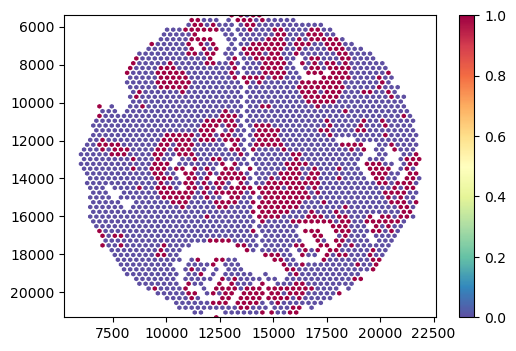

In [10]:
from matplotlib import cm as cm
import numpy as np
from matplotlib import pyplot as plt

x = Sample3.obs["imagerow"] 
y = Sample3.obs["imagecol"] 

c = pred

fig1 = plt.gcf()
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 400
plt.hexbin(y,x, C=c, cmap=cm.Spectral_r, gridsize=110)
plt.ylim(max(x), min(x)) 
plt.colorbar()
plt.show() 
#plt.draw()
#fig1.savefig(wd+'PABPC1_pred-FFPE.jpeg')

# Spatial Autocorrelation  p-value = 0.01

The `dill` module is required to use the sqlite backend fully.


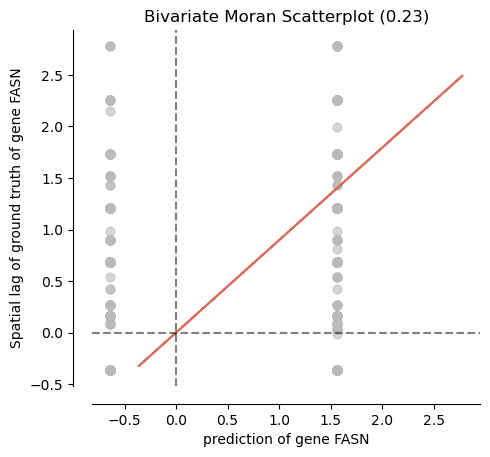

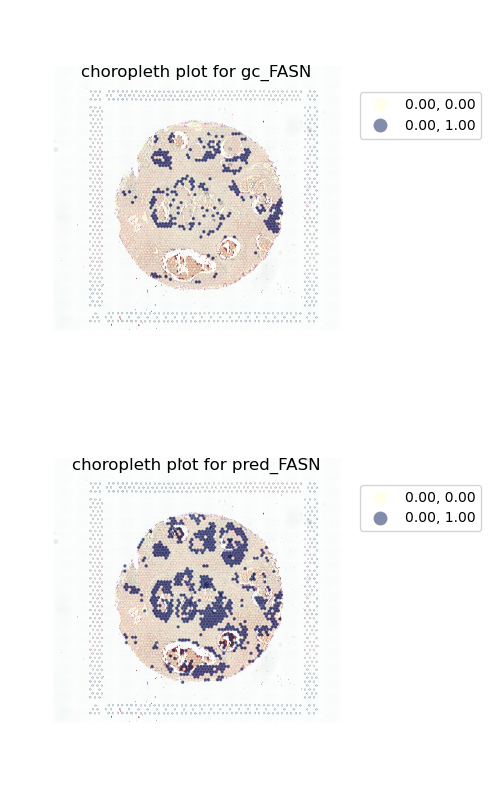

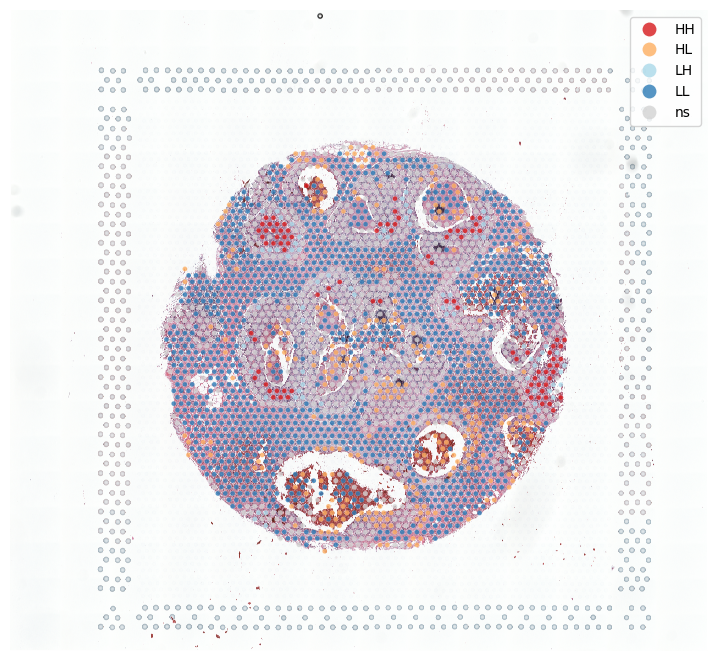

In [12]:
import joblib
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pysal
from pysal.explore import esda
import pysal.lib as lps
from esda.moran import Moran, Moran_Local, Moran_BV, Moran_Local_BV
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import os


def Spatial_AutoCorr(Sample_set1, Sample_set2, Model, test_X, gene, wd):
    Sample_set2.obsm["gpd"] = gpd.GeoDataFrame(Sample_set2.obs,
                                                 geometry=gpd.points_from_xy(
                                                     Sample_set2.obs.imagecol, 
                                                     Sample_set2.obs.imagerow))

    MinMax_scaler_y_1 = preprocessing.MinMaxScaler(feature_range =(0, 1))
    MinMax_scaler_y_2 = preprocessing.MinMaxScaler(feature_range =(0, 1))

    Y_1 = Sample_set1.to_df()[biomarker_list_1]
    Y_1 = MinMax_scaler_y_1.fit_transform(Y_1) 
    Y_1 = pd.DataFrame(data=Y_1)
    Y_1 = Y_1.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1.01], labels = [0, 1])); Y_1 = Y_1.astype('int64')


    test_Y_1 = Sample_set2.to_df()[biomarker_list_1]
    test_Y_1 = MinMax_scaler_y_2.fit_transform(test_Y_1)
    test_Y_1 = pd.DataFrame(data=test_Y_1)
    test_Y_1 = test_Y_1.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1.01], labels = [0, 1]))
    test_Y_1 = test_Y_1.fillna(0); test_Y_1 = test_Y_1.astype('int64')


    w = Queen.from_dataframe(Sample_set2.obsm["gpd"])

    y = Model.predict(test_X)

    x = test_Y_1[[0]].values
    Sample_set2.obsm["gpd"]["gc_{}".format(gene)] = x
    Sample_set2.obsm["gpd"]["pred_{}".format(gene)] = y
    tissue_image = Sample_set2.uns["spatial"]["FFPE_Breast_Cancer"]["images"]["fulres"]
    
    
    moran = Moran(y,w)
    moran_bv = Moran_BV(y, x, w)
    moran_loc = Moran_Local(y, w)
    moran_loc_bv = Moran_Local_BV(y, x, w)

    fig, ax = plt.subplots(figsize=(5,5))
    moran_plot = moran_scatterplot(moran_bv, ax=ax)
    ax.set_xlabel('prediction of gene {}'.format(gene))
    ax.set_ylabel('Spatial lag of ground truth of gene {}'.format(gene))
    plt.tight_layout()
    plt.show()


    def plot_choropleth(gdf, 
                        attribute_1,
                        attribute_2,
                        bg_img,
                        alpha=0.5,
                        scheme='Quantiles', 
                        cmap='YlGnBu', 
                        legend=True):

        fig, axs = plt.subplots(2,1, figsize=(5, 8),
                                subplot_kw={'adjustable':'datalim'})

        # Choropleth for attribute_1
        gdf.plot(column=attribute_1, scheme=scheme, cmap=cmap,
                 legend=legend, legend_kwds={'loc': 'upper left',
                                             'bbox_to_anchor': (0.92, 0.8)},
                 ax=axs[0], alpha=alpha, markersize=2)

        axs[0].imshow(bg_img)
        axs[0].set_title('choropleth plot for {}'.format(attribute_1), y=0.8)
        axs[0].set_axis_off()

        # Choropleth for attribute_2
        gdf.plot(column=attribute_2, scheme=scheme, cmap=cmap,
                 legend=legend, legend_kwds={'loc': 'upper left',
                                             'bbox_to_anchor': (0.92, 0.8)},
                 ax=axs[1], alpha=alpha, markersize=2)

        axs[1].imshow(bg_img)
        axs[1].set_title('choropleth plot for {}'.format(attribute_2), y=0.8)
        axs[1].set_axis_off()

        plt.tight_layout()

        return fig, ax

    choropleth_plot = plot_choropleth(Sample_set2.obsm["gpd"], "gc_{}".format(gene),"pred_{}".format(gene),tissue_image)
    plt.show()

    lisa_cluster(moran_loc_bv, Sample_set2.obsm["gpd"], p=0.01, 
                 figsize = (9,9), markersize=12, **{"alpha":0.8})
    lisa_plot = plt.imshow(Sample_set2.uns["spatial"]["FFPE_Breast_Cancer"]["images"]["fulres"])
    plt.show()
    return moran_plot, choropleth_plot, lisa_plot



gene = "FASN"
Sample_set1 = Sample1
Sample_set2 = Sample3
wd = 'D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/'
test_X = X_test_ffpe
Model = clf
a,b,c = Spatial_AutoCorr(Sample_set1, Sample_set2, Model, test_X, gene, wd)

# Spatial Autocorrelation p-val = 0.5

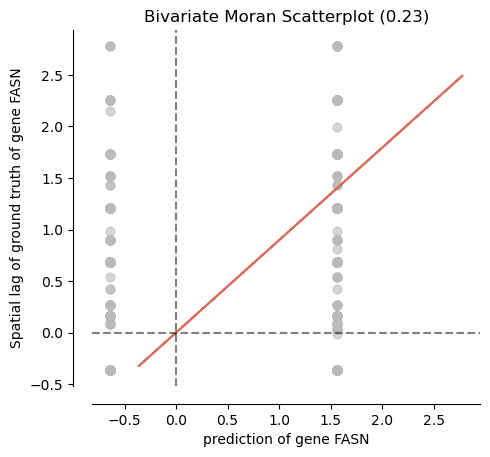

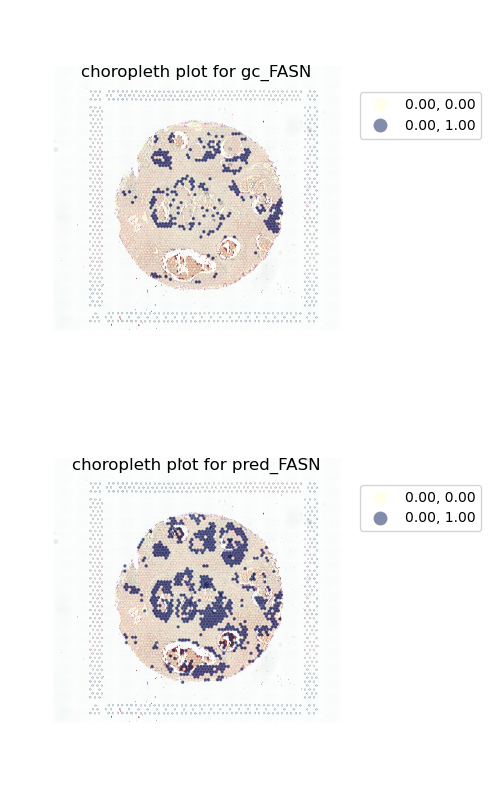

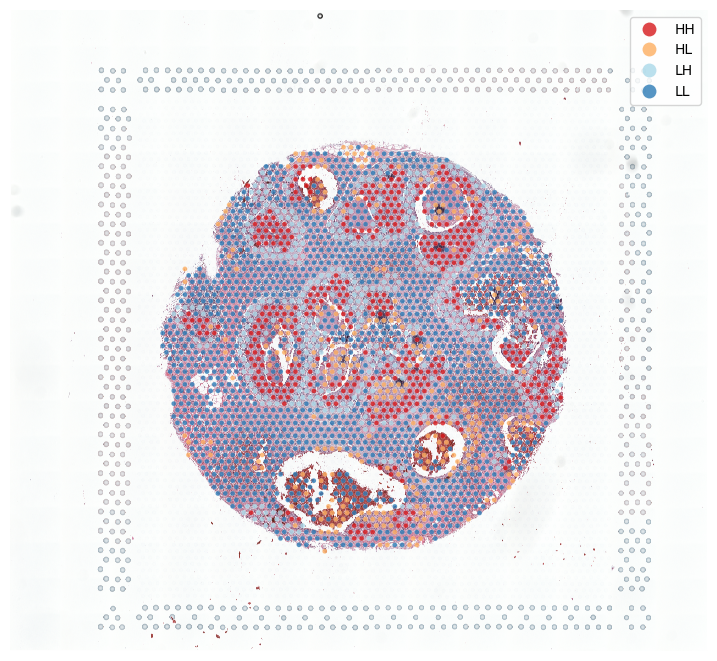

In [15]:
import joblib
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pysal
from pysal.explore import esda
import pysal.lib as lps
from esda.moran import Moran, Moran_Local, Moran_BV, Moran_Local_BV
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import os


def Spatial_AutoCorr(Sample_set1, Sample_set2, Model, test_X, gene, wd):
    Sample_set2.obsm["gpd"] = gpd.GeoDataFrame(Sample_set2.obs,
                                                 geometry=gpd.points_from_xy(
                                                     Sample_set2.obs.imagecol, 
                                                     Sample_set2.obs.imagerow))

    MinMax_scaler_y_1 = preprocessing.MinMaxScaler(feature_range =(0, 1))
    MinMax_scaler_y_2 = preprocessing.MinMaxScaler(feature_range =(0, 1))

    Y_1 = Sample_set1.to_df()[biomarker_list_1]
    Y_1 = MinMax_scaler_y_1.fit_transform(Y_1) 
    Y_1 = pd.DataFrame(data=Y_1)
    Y_1 = Y_1.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1.01], labels = [0, 1])); Y_1 = Y_1.astype('int64')


    test_Y_1 = Sample_set2.to_df()[biomarker_list_1]
    test_Y_1 = MinMax_scaler_y_2.fit_transform(test_Y_1)
    test_Y_1 = pd.DataFrame(data=test_Y_1)
    test_Y_1 = test_Y_1.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1.01], labels = [0, 1]))
    test_Y_1 = test_Y_1.fillna(0); test_Y_1 = test_Y_1.astype('int64')


    w = Queen.from_dataframe(Sample_set2.obsm["gpd"])

    y = Model.predict(test_X)

    x = test_Y_1[[0]].values
    Sample_set2.obsm["gpd"]["gc_{}".format(gene)] = x
    Sample_set2.obsm["gpd"]["pred_{}".format(gene)] = y
    tissue_image = Sample_set2.uns["spatial"]["FFPE_Breast_Cancer"]["images"]["fulres"]
    
    
    moran = Moran(y,w)
    moran_bv = Moran_BV(y, x, w)
    moran_loc = Moran_Local(y, w)
    moran_loc_bv = Moran_Local_BV(y, x, w)

    fig, ax = plt.subplots(figsize=(5,5))
    moran_plot = moran_scatterplot(moran_bv, ax=ax)
    ax.set_xlabel('prediction of gene {}'.format(gene))
    ax.set_ylabel('Spatial lag of ground truth of gene {}'.format(gene))
    plt.tight_layout()
    plt.show()


    def plot_choropleth(gdf, 
                        attribute_1,
                        attribute_2,
                        bg_img,
                        alpha=0.5,
                        scheme='Quantiles', 
                        cmap='YlGnBu', 
                        legend=True):

        fig, axs = plt.subplots(2,1, figsize=(5, 8),
                                subplot_kw={'adjustable':'datalim'})

        # Choropleth for attribute_1
        gdf.plot(column=attribute_1, scheme=scheme, cmap=cmap,
                 legend=legend, legend_kwds={'loc': 'upper left',
                                             'bbox_to_anchor': (0.92, 0.8)},
                 ax=axs[0], alpha=alpha, markersize=2)

        axs[0].imshow(bg_img)
        axs[0].set_title('choropleth plot for {}'.format(attribute_1), y=0.8)
        axs[0].set_axis_off()

        # Choropleth for attribute_2
        gdf.plot(column=attribute_2, scheme=scheme, cmap=cmap,
                 legend=legend, legend_kwds={'loc': 'upper left',
                                             'bbox_to_anchor': (0.92, 0.8)},
                 ax=axs[1], alpha=alpha, markersize=2)

        axs[1].imshow(bg_img)
        axs[1].set_title('choropleth plot for {}'.format(attribute_2), y=0.8)
        axs[1].set_axis_off()

        plt.tight_layout()

        return fig, ax

    choropleth_plot = plot_choropleth(Sample_set2.obsm["gpd"], "gc_{}".format(gene),"pred_{}".format(gene),tissue_image)
    plt.show()

    lisa_cluster(moran_loc_bv, Sample_set2.obsm["gpd"], p=0.5, 
                 figsize = (9,9), markersize=12, **{"alpha":0.8})
    lisa_plot = plt.imshow(Sample_set2.uns["spatial"]["FFPE_Breast_Cancer"]["images"]["fulres"])
    plt.show()
    return moran_plot, choropleth_plot, lisa_plot



gene = "FASN"
Sample_set1 = Sample1
Sample_set2 = Sample3
wd = 'D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/'
test_X = X_test_ffpe
Model = clf
a,b,c = Spatial_AutoCorr(Sample_set1, Sample_set2, Model, test_X, gene, wd)

In [25]:
Sample3.obsm["gpd"]

in_tissue  array_row  array_col  sum_counts  imagecol  \
AAACAAGTATCTCCCA-1          1         50        102     21201.0     19934   
AAACACCAATAACTGC-1          1         59         19      5672.0      7893   
AAACAGAGCGACTCCT-1          1         14         94     13042.0     18782   
AAACAGCTTTCAGAAG-1          1         43          9      5527.0      6446   
AAACAGGGTCTATATT-1          1         47         13      4591.0      7025   
...                       ...        ...        ...         ...       ...   
TTGTTCAGTGTGCTAC-1          1         24         64      8648.0     14428   
TTGTTGTGTGTCAAGA-1          1         31         77     13509.0     16312   
TTGTTTCACATCCAGG-1          1         58         42      2994.0     11229   
TTGTTTCATTAGTCTA-1          1         60         30      8074.0      9488   
TTGTTTCCATACAACT-1          1         45         27      4482.0      9056   

                    imagerow  n_counts                     geometry  gc_FASN  \
AAACAAGTATCTCCCA-1     16265   21200.0  POINT (19934.000 16265.000)        0   
AAACACCAATAACTGC-1     18526    5672.0   POINT (7893.000 18526.000)        0   
AAACAGAGCGACTCCT-1      7178   13042.0   POINT (18782.000 7178.000)        0   
AAACAGCTTTCAGAAG-1     14487    5527.0   POINT (6446.000 14487.000)        0   
AAACAGGGTCTATATT-1     15497    4591.0   POINT (7025.000 15497.000)        0   
...                      ...       ...                          ...      ...   
TTGTTCAGTGTGCTAC-1      9698    8648.0   POINT (14428.000 9698.000)        0   
TTGTTGTGTGTCAAGA-1     11467   13509.0  POINT (16312.000 11467.000)        0   
TTGTTTCACATCCAGG-1     18277    2994.0  POINT (11229.000 18277.000)        0   
TTGTTTCATTAGTCTA-1     18780    8074.0   POINT (9488.000 18780.000)        0   
TTGTTTCCATACAACT-1     14994    4480.0   POINT (9056.000 14994.000)        0   

                    pred_FASN  
AAACAAGTATCTCCCA-1          1  
AAACACCAATAACTGC-1          0  
AAACAGAGCGACTCCT-1          0  
AAACAGCTTTCAGAAG-1          0  
AAACAGGGTCTATATT-1          0  
...                       ...  
TTGTTCAGTGTGCTAC-1          0  
TTGTTGTGTGTCAAGA-1          0  
TTGTTTCACATCCAGG-1          0  
TTGTTTCATTAGTCTA-1          0  
TTGTTTCCATACAACT-1          0  

[2518 rows x 10 columns]

# Visualisation GE

# COX6C 10X

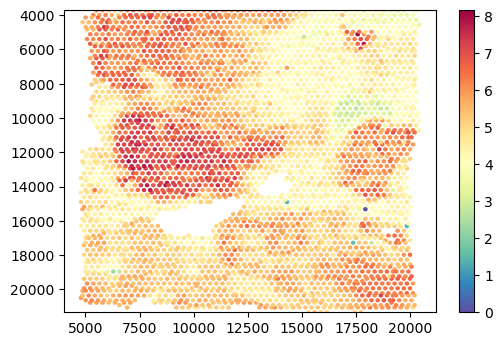

In [19]:
from matplotlib import cm as cm
import numpy as np
from matplotlib import pyplot as plt

x = Sample2.obs["imagerow"] 
y = Sample2.obs["imagecol"] 

c = Sample2.to_df()["COX6C"]#test_Y_1#

fig1 = plt.gcf()
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 400
plt.hexbin(y,x, C=c, cmap=cm.Spectral_r, gridsize=110)
plt.ylim(max(x), min(x)) 
plt.colorbar()
plt.show() 
#plt.draw()
#fig1.savefig(wd+'PABPC1_true-FFPE.jpeg')

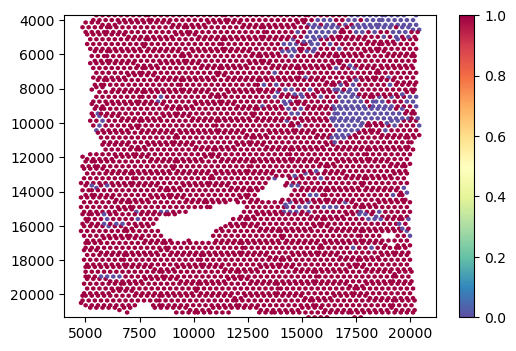

In [20]:
from matplotlib import cm as cm
import numpy as np
from matplotlib import pyplot as plt

x = Sample2.obs["imagerow"] 
y = Sample2.obs["imagecol"] 

c = test_Y_1

fig1 = plt.gcf()
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 400
plt.hexbin(y,x, C=c, cmap=cm.Spectral_r, gridsize=110)
plt.ylim(max(x), min(x)) 
plt.colorbar()
plt.show() 
#plt.draw()
#fig1.savefig(wd+'PABPC1_true-FFPE.jpeg')

### Predicted

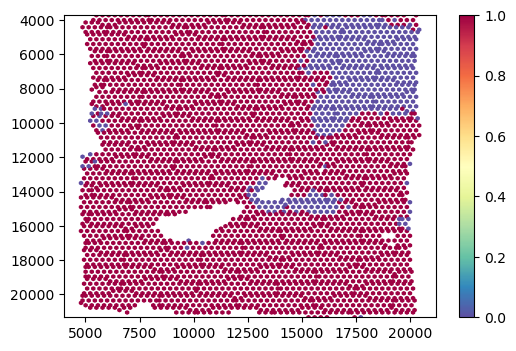

In [21]:
from matplotlib import cm as cm
import numpy as np
from matplotlib import pyplot as plt

x = Sample2.obs["imagerow"] 
y = Sample2.obs["imagecol"] 

c = pred

fig1 = plt.gcf()
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 400
plt.hexbin(y,x, C=c, cmap=cm.Spectral_r, gridsize=110)
plt.ylim(max(x), min(x)) 
plt.colorbar()
plt.show() 
#plt.draw()
#fig1.savefig(wd+'PABPC1_true-FFPE.jpeg')

# Spatial Autocorrelation p-value 0.01

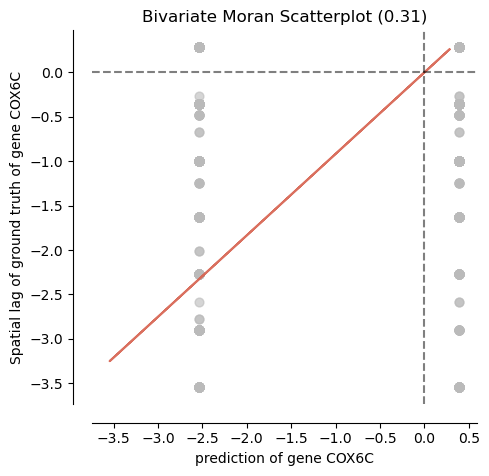

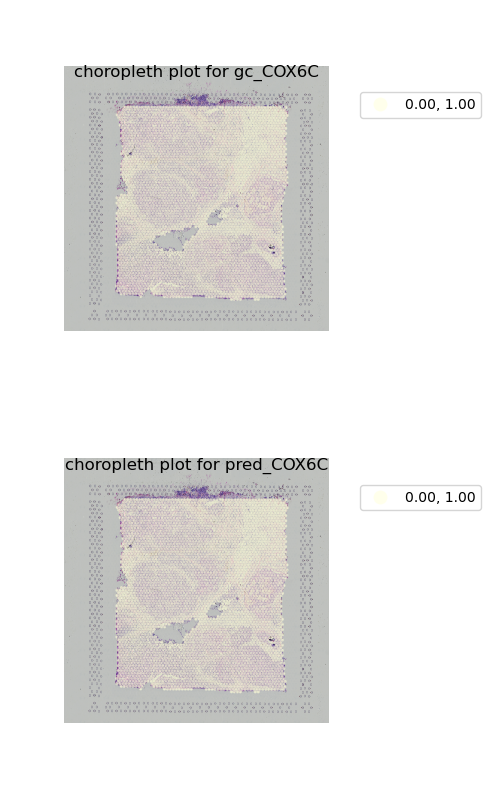

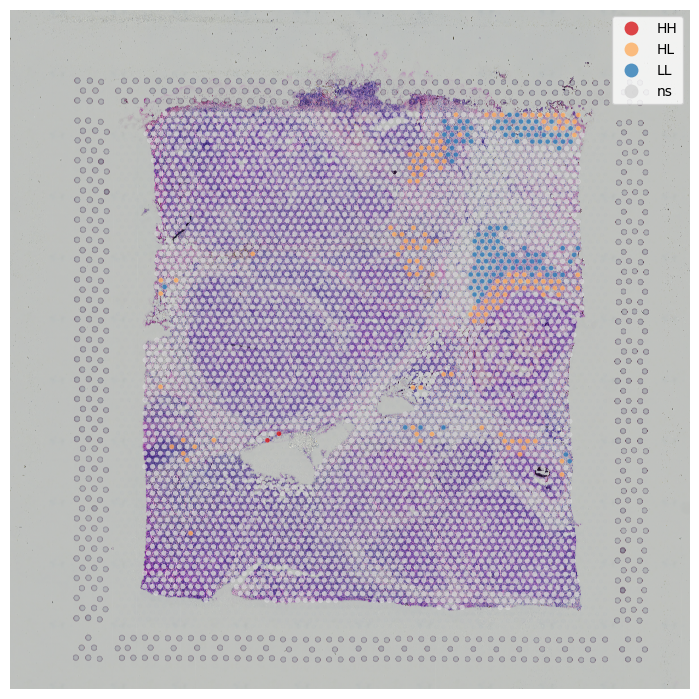

In [22]:
import joblib
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pysal
from pysal.explore import esda
import pysal.lib as lps
from esda.moran import Moran, Moran_Local, Moran_BV, Moran_Local_BV
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import os


def Spatial_AutoCorr(Sample_set1, Sample_set2, Model, test_X, gene, wd):
    Sample_set2.obsm["gpd"] = gpd.GeoDataFrame(Sample_set2.obs,
                                                 geometry=gpd.points_from_xy(
                                                     Sample_set2.obs.imagecol, 
                                                     Sample_set2.obs.imagerow))

    MinMax_scaler_y_1 = preprocessing.MinMaxScaler(feature_range =(0, 1))
    MinMax_scaler_y_2 = preprocessing.MinMaxScaler(feature_range =(0, 1))

    Y_1 = Sample_set1.to_df()[biomarker_list_1]
    Y_1 = MinMax_scaler_y_1.fit_transform(Y_1) 
    Y_1 = pd.DataFrame(data=Y_1)
    Y_1 = Y_1.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1.01], labels = [0, 1])); Y_1 = Y_1.astype('int64')


    test_Y_1 = Sample_set2.to_df()[biomarker_list_1]
    test_Y_1 = MinMax_scaler_y_2.fit_transform(test_Y_1)
    test_Y_1 = pd.DataFrame(data=test_Y_1)
    test_Y_1 = test_Y_1.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1.01], labels = [0, 1]))
    test_Y_1 = test_Y_1.fillna(0); test_Y_1 = test_Y_1.astype('int64')


    w = Queen.from_dataframe(Sample_set2.obsm["gpd"])

    y = Model.predict(test_X)

    x = test_Y_1[[0]].values
    Sample_set2.obsm["gpd"]["gc_{}".format(gene)] = x
    Sample_set2.obsm["gpd"]["pred_{}".format(gene)] = y
    tissue_image = Sample_set2.uns["spatial"]["block2"]["images"]["fulres"]
    
    
    moran = Moran(y,w)
    moran_bv = Moran_BV(y, x, w)
    moran_loc = Moran_Local(y, w)
    moran_loc_bv = Moran_Local_BV(y, x, w)

    fig, ax = plt.subplots(figsize=(5,5))
    moran_plot = moran_scatterplot(moran_bv, ax=ax)
    ax.set_xlabel('prediction of gene {}'.format(gene))
    ax.set_ylabel('Spatial lag of ground truth of gene {}'.format(gene))
    plt.tight_layout()
    plt.show()


    def plot_choropleth(gdf, 
                        attribute_1,
                        attribute_2,
                        bg_img,
                        alpha=0.5,
                        scheme='Quantiles', 
                        cmap='YlGnBu', 
                        legend=True):

        fig, axs = plt.subplots(2,1, figsize=(5, 8),
                                subplot_kw={'adjustable':'datalim'})

        # Choropleth for attribute_1
        gdf.plot(column=attribute_1, scheme=scheme, cmap=cmap,
                 legend=legend, legend_kwds={'loc': 'upper left',
                                             'bbox_to_anchor': (0.92, 0.8)},
                 ax=axs[0], alpha=alpha, markersize=2)

        axs[0].imshow(bg_img)
        axs[0].set_title('choropleth plot for {}'.format(attribute_1), y=0.8)
        axs[0].set_axis_off()

        # Choropleth for attribute_2
        gdf.plot(column=attribute_2, scheme=scheme, cmap=cmap,
                 legend=legend, legend_kwds={'loc': 'upper left',
                                             'bbox_to_anchor': (0.92, 0.8)},
                 ax=axs[1], alpha=alpha, markersize=2)

        axs[1].imshow(bg_img)
        axs[1].set_title('choropleth plot for {}'.format(attribute_2), y=0.8)
        axs[1].set_axis_off()

        plt.tight_layout()

        return fig, ax

    choropleth_plot = plot_choropleth(Sample_set2.obsm["gpd"], "gc_{}".format(gene),"pred_{}".format(gene),tissue_image)
    plt.show()

    lisa_cluster(moran_loc_bv, Sample_set2.obsm["gpd"], p=0.01, 
                 figsize = (9,9), markersize=12, **{"alpha":0.8})
    lisa_plot = plt.imshow(Sample_set2.uns["spatial"]["block2"]["images"]["fulres"])
    plt.show()
    return moran_plot, choropleth_plot, lisa_plot



gene = "COX6C"
Sample_set1 = Sample1
Sample_set2 = Sample2
wd = 'D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/'
test_X = X_test
Model = clf
a,b,c = Spatial_AutoCorr(Sample_set1, Sample_set2, Model, test_X, gene, wd)

# Spatial Autocorrelation p-value 0.5

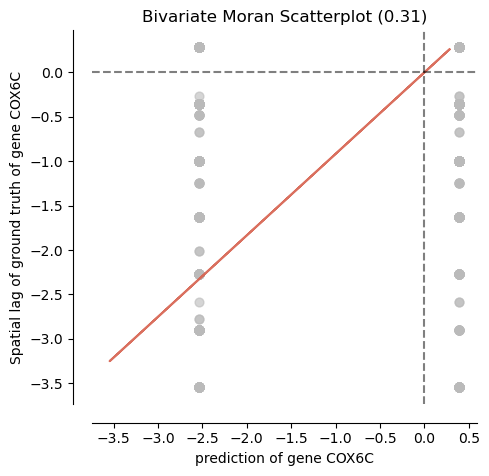

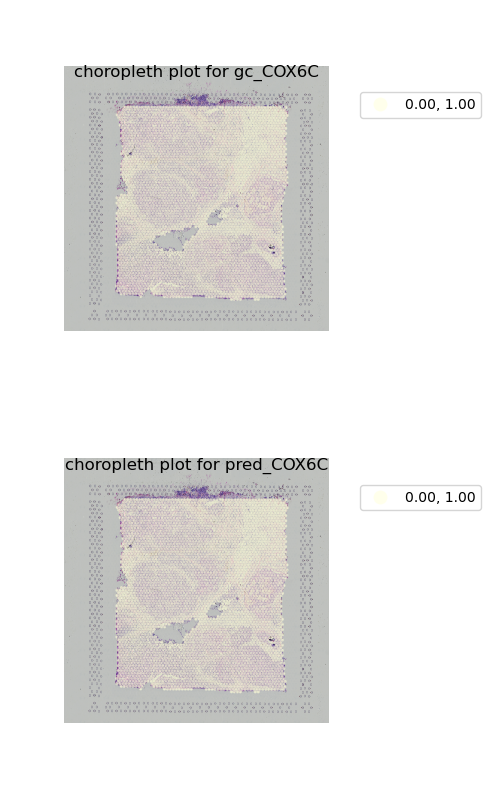

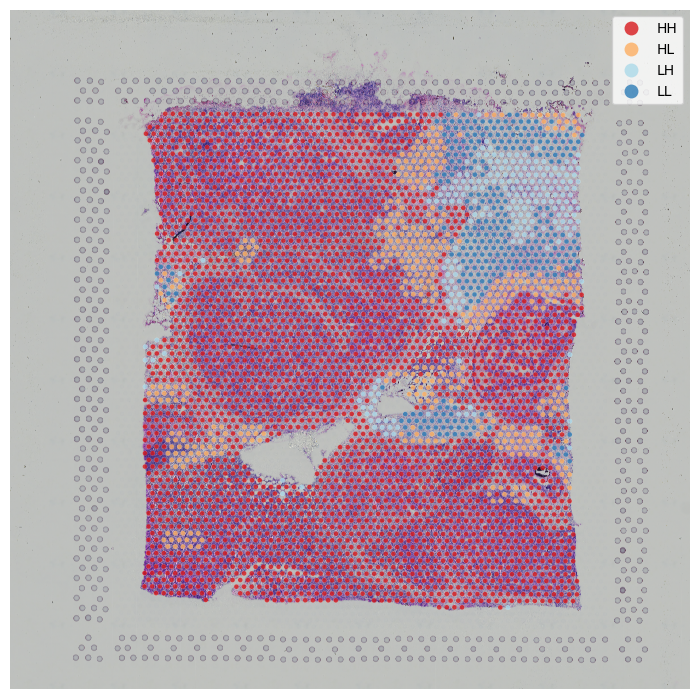

In [23]:
import joblib
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pysal
from pysal.explore import esda
import pysal.lib as lps
from esda.moran import Moran, Moran_Local, Moran_BV, Moran_Local_BV
import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster, plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import os


def Spatial_AutoCorr(Sample_set1, Sample_set2, Model, test_X, gene, wd):
    Sample_set2.obsm["gpd"] = gpd.GeoDataFrame(Sample_set2.obs,
                                                 geometry=gpd.points_from_xy(
                                                     Sample_set2.obs.imagecol, 
                                                     Sample_set2.obs.imagerow))

    MinMax_scaler_y_1 = preprocessing.MinMaxScaler(feature_range =(0, 1))
    MinMax_scaler_y_2 = preprocessing.MinMaxScaler(feature_range =(0, 1))

    Y_1 = Sample_set1.to_df()[biomarker_list_1]
    Y_1 = MinMax_scaler_y_1.fit_transform(Y_1) 
    Y_1 = pd.DataFrame(data=Y_1)
    Y_1 = Y_1.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1.01], labels = [0, 1])); Y_1 = Y_1.astype('int64')


    test_Y_1 = Sample_set2.to_df()[biomarker_list_1]
    test_Y_1 = MinMax_scaler_y_2.fit_transform(test_Y_1)
    test_Y_1 = pd.DataFrame(data=test_Y_1)
    test_Y_1 = test_Y_1.apply(lambda x: pd.cut(x, bins=[-0.01, 0.5, 1.01], labels = [0, 1]))
    test_Y_1 = test_Y_1.fillna(0); test_Y_1 = test_Y_1.astype('int64')


    w = Queen.from_dataframe(Sample_set2.obsm["gpd"])

    y = Model.predict(test_X)

    x = test_Y_1[[0]].values
    Sample_set2.obsm["gpd"]["gc_{}".format(gene)] = x
    Sample_set2.obsm["gpd"]["pred_{}".format(gene)] = y
    tissue_image = Sample_set2.uns["spatial"]["block2"]["images"]["fulres"]
    
    
    moran = Moran(y,w)
    moran_bv = Moran_BV(y, x, w)
    moran_loc = Moran_Local(y, w)
    moran_loc_bv = Moran_Local_BV(y, x, w)

    fig, ax = plt.subplots(figsize=(5,5))
    moran_plot = moran_scatterplot(moran_bv, ax=ax)
    ax.set_xlabel('prediction of gene {}'.format(gene))
    ax.set_ylabel('Spatial lag of ground truth of gene {}'.format(gene))
    plt.tight_layout()
    plt.show()


    def plot_choropleth(gdf, 
                        attribute_1,
                        attribute_2,
                        bg_img,
                        alpha=0.5,
                        scheme='Quantiles', 
                        cmap='YlGnBu', 
                        legend=True):

        fig, axs = plt.subplots(2,1, figsize=(5, 8),
                                subplot_kw={'adjustable':'datalim'})

        # Choropleth for attribute_1
        gdf.plot(column=attribute_1, scheme=scheme, cmap=cmap,
                 legend=legend, legend_kwds={'loc': 'upper left',
                                             'bbox_to_anchor': (0.92, 0.8)},
                 ax=axs[0], alpha=alpha, markersize=2)

        axs[0].imshow(bg_img)
        axs[0].set_title('choropleth plot for {}'.format(attribute_1), y=0.8)
        axs[0].set_axis_off()

        # Choropleth for attribute_2
        gdf.plot(column=attribute_2, scheme=scheme, cmap=cmap,
                 legend=legend, legend_kwds={'loc': 'upper left',
                                             'bbox_to_anchor': (0.92, 0.8)},
                 ax=axs[1], alpha=alpha, markersize=2)

        axs[1].imshow(bg_img)
        axs[1].set_title('choropleth plot for {}'.format(attribute_2), y=0.8)
        axs[1].set_axis_off()

        plt.tight_layout()

        return fig, ax

    choropleth_plot = plot_choropleth(Sample_set2.obsm["gpd"], "gc_{}".format(gene),"pred_{}".format(gene),tissue_image)
    plt.show()

    lisa_cluster(moran_loc_bv, Sample_set2.obsm["gpd"], p=0.5, 
                 figsize = (9,9), markersize=12, **{"alpha":0.8})
    lisa_plot = plt.imshow(Sample_set2.uns["spatial"]["block2"]["images"]["fulres"])
    plt.show()
    return moran_plot, choropleth_plot, lisa_plot



gene = "COX6C"
Sample_set1 = Sample1
Sample_set2 = Sample2
wd = 'D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/'
test_X = X_test
Model = clf
a,b,c = Spatial_AutoCorr(Sample_set1, Sample_set2, Model, test_X, gene, wd)

In [24]:
Sample2.obsm["gpd"]

in_tissue  array_row  array_col  sum_counts  imagecol  \
AAACAACGAATAGTTC-1          1          0         16     17367.0      6080   
AAACAAGTATCTCCCA-1          1         50        102      9873.0     17782   
AAACAATCTACTAGCA-1          1          3         43     29133.0      9763   
AAACACCAATAACTGC-1          1         59         19     31487.0      6447   
AAACAGAGCGACTCCT-1          1         14         94     10707.0     16716   
...                       ...        ...        ...         ...       ...   
TTGTTTCACATCCAGG-1          1         58         42     22138.0      9587   
TTGTTTCATTAGTCTA-1          1         60         30     24764.0      7947   
TTGTTTCCATACAACT-1          1         45         27     11746.0      7549   
TTGTTTGTATTACACG-1          1         73         41     30192.0      9439   
TTGTTTGTGTAAATTC-1          1          7         51     16695.0     10852   

                    imagerow     n_counts                     geometry  \
AAACAACGAATAGTTC-1      3722  5917.174805    POINT (6080.000 3722.000)   
AAACAAGTATCTCCCA-1     15632  3976.538330  POINT (17782.000 15632.000)   
AAACAATCTACTAGCA-1      4445  8482.242188    POINT (9763.000 4445.000)   
AAACACCAATAACTGC-1     17734  8715.427734   POINT (6447.000 17734.000)   
AAACAGAGCGACTCCT-1      7079  4342.504883   POINT (16716.000 7079.000)   
...                      ...          ...                          ...   
TTGTTTCACATCCAGG-1     17507  6689.778320   POINT (9587.000 17507.000)   
TTGTTTCATTAGTCTA-1     17976  7505.065918   POINT (7947.000 17976.000)   
TTGTTTCCATACAACT-1     14413  4425.141602   POINT (7549.000 14413.000)   
TTGTTTGTATTACACG-1     21068  8480.497070   POINT (9439.000 21068.000)   
TTGTTTGTGTAAATTC-1      5399  6203.332031   POINT (10852.000 5399.000)   

                    gc_COX6C  pred_COX6C  
AAACAACGAATAGTTC-1         1           1  
AAACAAGTATCTCCCA-1         1           1  
AAACAATCTACTAGCA-1         1           1  
AAACACCAATAACTGC-1         1           1  
AAACAGAGCGACTCCT-1         1           0  
...                      ...         ...  
TTGTTTCACATCCAGG-1         1           1  
TTGTTTCATTAGTCTA-1         1           1  
TTGTTTCCATACAACT-1         1           1  
TTGTTTGTATTACACG-1         1           1  
TTGTTTGTGTAAATTC-1         1           1  

[3986 rows x 10 columns]

# LIME difficult to build because Classification-model takes 2 images as Input whereas LIME take only one

# Ignore below sections please... it's just practice codes

In [16]:
Model_classifier = clf

resnet_model = ResNet50(weights="imagenet", include_top=False, input_shape=(299, 299, 3), pooling="avg")
gene_list = ["COX6C"]

    
def model_predict_gene(gene):
    i = gene_list.index(gene)
    def combine_model_predict(tile):
        feature = resnet_model.predict(tile)
        feature = feature.reshape((10, 2048))
        prediction = Model_classifier.predict_proba(feature)
        return prediction[i]
    return combine_model_predict


def pred_label(tile):
    feature = resnet_model.predict(tile)
    feature = feature.reshape((1, 2048))
    prediction = Model_classifier.predict_proba(feature)
    return prediction

def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image_fun.load_img(img_path, target_size=(299, 299))
        x = image_fun.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        out.append(x)
    return np.vstack(out)

def watershed_segment(image):
    annotation_hed = rgb2hed(image)
    annotation_h = annotation_hed[:,:,0]
    annotation_h *= 255.0 / np.percentile(annotation_h, q=80)
    thresh = skimage.filters.threshold_otsu(annotation_h)
    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        annotation_h < thresh
    )
    distance = ndi.distance_transform_edt(im_fgnd_mask)
    coords = peak_local_max(distance, footprint=np.ones((5, 5)), labels=im_fgnd_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(annotation_h, markers, mask=im_fgnd_mask)
    im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)
    map_dic = dict(zip(np.unique(im_nuclei_seg_mask), np.arange(len(np.unique(im_nuclei_seg_mask)))))
    im_nuclei_seg_mask = np.vectorize(map_dic.get)(im_nuclei_seg_mask)
    return im_nuclei_seg_mask

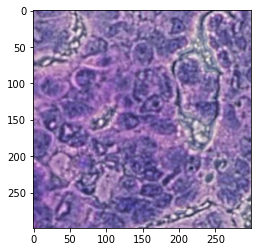

In [15]:
plt.imshow(Image.open('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/tiles/block2/block2-7831-11564-299.jpeg'))

In [18]:
images = transform_img_fn([os.path.join('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/tiles/block2/block2-7831-11564-299.jpeg')])
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(images[0].astype('double'), model_predict_gene("COX6C"), segmentation_fn= watershed_segment, top_labels=2, num_samples=100)
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[1]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -1, vmax = 1)
plt.colorbar()

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


  0%|          | 0/100 [00:00<?, ?it/s]

ValueError: X has 2048 features, but MLPClassifier is expecting 4096 features as input.

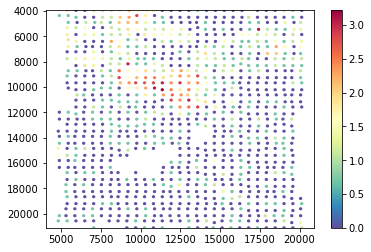

In [112]:
from matplotlib import cm as cm
import numpy as np
from matplotlib import pyplot as plt

x = Sample4["imagerow"].sort_index() 
y = Sample4["imagecol"].sort_index()

c = ge_2["LINC00645"].sort_index()

plt.hexbin(y,x, C=c, cmap=cm.Spectral_r, gridsize=110)
plt.ylim(max(x), min(x)) 
plt.colorbar()
plt.show() 

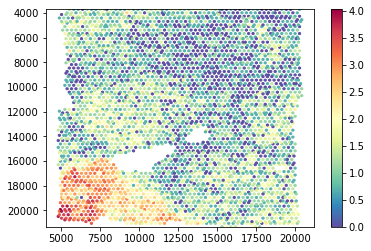

In [88]:
from matplotlib import cm as cm
import numpy as np
from matplotlib import pyplot as plt

x = Sample2.obs["imagerow"] 
y = Sample2.obs["imagecol"] 

c = Sample2.to_df()["TTLL12"]

plt.hexbin(y,x, C=c, cmap=cm.Spectral_r, gridsize=110)
plt.ylim(max(x), min(x)) 
plt.colorbar()
plt.show() 

## Visualisation

In [21]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

wd = 'D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Output_Spots_Image/'
wd1 = 'D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/'

def Visualise(image, Sample1):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    Spot_vals0=Sample1.values

    x = Spot_vals0[:,4].astype('int64')
    y = Spot_vals0[:,5].astype('int64')
    box = (x,y)
    numpy_array = np.array(box)
    transpose = numpy_array.T
    box = transpose.tolist()

    for i in range(0,len(box)):
        image=cv2.circle(image, tuple(box[i]), 75,(255,0,0), -1)

    cv2.imwrite(wd+"Trial-2.png",image)

image = cv2.imread(wd1+"block2/V1_Breast_Cancer_Block_A_Section_2_image.tif") 
Visualise(image, Sample3)

# Arrange Dataframe

In [67]:
"""def get_nearest_index(self, quary_spots, candidates, k_nn, leaf_size):
    tree = KDTree(candidates, leaf_size=leaf_size)
    _, indices = tree.query(quary_spots, k=k_nn)
    return indices.ravel()[1:]

candidates = self.adata.obs[['imagecol', 'imagerow']]
quary_spots = np.array(candidates.loc[obs_temp,:]).reshape(1, -1)
nearest_index = self.get_nearest_index(quary_spots, candidates, k_nn=7, leaf_size=self.adata.n_obs//2)

from sklearn.neighbors import KDTree
tree = KDTree(Sample2.obs[["imagerow","imagecol"]])              
dist, ind = tree.query(Sample3[["imagerow","imagecol"]], k=7)"""

"""wd = 'D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/'
pd.DataFrame(Sample1.obsm['X_tile_feature']).to_csv(wd+'Sample1_big.csv')
pd.DataFrame(Sample2.obsm['X_tile_feature']).to_csv(wd+'Sample2_big.csv')"""

'def get_nearest_index(self, quary_spots, candidates, k_nn, leaf_size):\n    tree = KDTree(candidates, leaf_size=leaf_size)\n    _, indices = tree.query(quary_spots, k=k_nn)\n    return indices.ravel()[1:]\n\ncandidates = self.adata.obs[[\'imagecol\', \'imagerow\']]\nquary_spots = np.array(candidates.loc[obs_temp,:]).reshape(1, -1)\nnearest_index = self.get_nearest_index(quary_spots, candidates, k_nn=7, leaf_size=self.adata.n_obs//2)\n\nfrom sklearn.neighbors import KDTree\ntree = KDTree(Sample2.obs[["imagerow","imagecol"]])              \ndist, ind = tree.query(Sample3[["imagerow","imagecol"]], k=7)'

In [92]:
list1 = []
start, end = Sample1.obs["array_row"].min(), Sample1.obs["array_row"].max()
for num in range(start, end + 1):
    if num % 2 == 0:
        list1.append(num)
        
list2 = []
start, end = Sample1.obs["array_col"].min(), Sample1.obs["array_col"].max()
for num in range(start, end + 1):
    if num % 2 == 1:
        list2.append(num)
list2 = list2[1::2]

list3 = []
start, end = Sample2.obs["array_row"].min(), Sample2.obs["array_row"].max()
for num in range(start, end + 1):
    if num % 2 == 0:
        list3.append(num)
        
list4 = []
start, end = Sample2.obs["array_col"].min(), Sample2.obs["array_col"].max()
for num in range(start, end + 1):
    if num % 2 == 1:
        list4.append(num)
list4 = list4[1::2]

Sample3 = copy.copy(Sample1.obs.sort_values(["array_row"]))
Sample3 = Sample3[~Sample3['array_row'].isin(list1)]
Sample3 = Sample3[~Sample3['array_col'].isin(list2)].sort_index()

Sample4 = copy.copy(Sample2.obs.sort_values(["array_row"]))
Sample4 = Sample4[~Sample4['array_row'].isin(list3)]
Sample4 = Sample4[~Sample4['array_col'].isin(list4)].sort_index()

Sample1_resnet = pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Sample1_1000.csv')
Sample1_resnet.index = Sample1.obs.index
Sample2_resnet = pd.read_csv('D:/onkar/Projects/Project_Spt.Transcriptomics/Output_files/Sample2_1000.csv')
Sample2_resnet.index = Sample2.obs.index

Sample1_resnet = Sample1_resnet[Sample1_resnet.index.isin(Sample3.index)]
Sample1_resnet = Sample1_resnet.drop(["Unnamed: 0"], axis=1)
Sample2_resnet = Sample2_resnet[Sample2_resnet.index.isin(Sample4.index)]
Sample2_resnet = Sample2_resnet.drop(["Unnamed: 0"], axis=1)

ge_1 = Sample1.to_df()[Sample1.to_df().index.isin(Sample3.index)].sort_index()
ge_2 = Sample2.to_df()[Sample2.to_df().index.isin(Sample4.index)].sort_index()

In [114]:
Y_1_0 = Y_1[Y_1[0]==0]
Y_1_0_reg = ge_1.iloc[Y_1_0.index][biomarker_list_1]
X_1_0 = Sample1_resnet.iloc[Y_1_0.index]

Y_1_1 = Y_1[Y_1[0]==1]
Y_1_1_reg = ge_1.iloc[Y_1_1.index][biomarker_list_1]
X_1_1 = Sample1_resnet.iloc[Y_1_1.index]

clf_1 = model_c.fit(Sample1_resnet, Y_1)#MultiOutputClassifier(model).fit(X_1, Y_1) #joblib.dump(clf, wd+'ResNet50-LGBM_biomarker_gene.pkl')
reg_0 = model_r.fit(X_1_0, Y_1_0_reg)
reg_1 = model_r.fit(X_1_1, Y_1_1_reg)

GE = ge_2.reset_index(drop=True)
GE['class'] = clf_1.predict(Sample2_resnet)

GE_0 = GE[GE['class']==0]
GE_1 = GE[GE['class']==1]

test_X_1_0 = Sample2_resnet.iloc[GE_0.index]
test_X_1_1 = Sample2_resnet.iloc[GE_1.index]

r1 = reg_0.predict(test_X_1_0)
r2 = reg_1.predict(test_X_1_1)

Reg1 = pd.DataFrame(index = GE[GE['class']==0].index)
Reg1["r"] = r1
Reg2 = pd.DataFrame(index = GE[GE['class']==1].index)
Reg2["r"] = r2

Reg = pd.concat([Reg1,Reg2])
Reg = Reg.sort_index()
Reg.index = Sample4.index

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
